<a href="https://colab.research.google.com/github/GvdDool/Notebook-test/blob/master/Geo_Referencing_a_Figure_as_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Geo-Referencing a Figure as Image
---
*Creating a static background image from vector data to use as a standard map for MatLibPlot figures in a project showing spatial data to a fixed extent.*

---
##Motivation
Recently I started to work on a new research project, looking at patterns in natural event observations in Europe. To make the collaboration easier, I wanted to share my NoteBook with others, to work on the problem together and to show the results.
I am using at the moment a geographical library [GeoPandas 0.7.0], which includes a set of vector files. However, only US county outlines and the world countries are included, at a very coarse resolution (see figure below). The standard data can be used to generate maps, or even do some rough spatial analysis.
The boundary files are good enough to display country statistics on a world scale, and they can also be used at a regional level. The maps are not that useful anymore when the extent is reduced to country-level (e.g. the outline of France). In this case, external data should be used to create the figure to capture the desired details.

---

External vector data can come in many different "shapes" and formats, ranging from Shapefiles (being the most frequently used, ArcInfo Coverage, E00 ArcInfo Interchange, Spatial Database engine (ArcSDE), Digital Line Graph (DLG), GeoJSON, AutoCAD DXF, and Keyhole Markup Language (KML), to name a few.
The unique handling of the formats can't be avoided, each data type needs a specific method to load and visualise the data. This made me think that perhaps it would be possible to simplify the creation and sharing of the background map.
Like, what if everyone involved in the project would be looking at the same image/figure, in the same style and layout:

**A static background map!**

This is not a new concept, and won't be useful in all cases. Still, I was interested in exploring the possibility to create a method which:
- Standardises the background; so that I can focus on other aspects of the project instead of creating the same layout (but slightly different) for each plot in my project
- Simplifies the data exchange; shapefiles are most often used and widely available, the downside of using shapefiles is that they don't come as a single file, but are used as a collection (a minimum of 3 files and maximum 7 files are needed to display a shapefile).
- Reduces disk space; when handling (shape)files locally disk space is not a real concern, but when moving data to (free) cloud computing environments (Google CoLab in this example) disk space could start to be a problem. Background Raster Images are transferring at a fraction of the size of their Vector counterparts
- Reduces figure creation/displaying time, again depending on your local system or cloud computing environment, this might not be an issue. However, raster-based maps are generated much faster than vector-based maps (mainly because of the resolution of the data, vectors have more computing "points" than rasters).
- Is a challenge to get right; this last point is personal, and an exercise in learning new coding libraries to handle geographical information.

I believe the method outlined here, and stored in the linked NoteBook, is doing a reasonably good job converting an image to a GeoTiff and reusing the information in another figure. I am happy to share the NoteBook, and I hope the code will work for you, and that you can test it in your project; I am looking forward to the reactions and feedback in the comments.

---


##General Instructions

The text in this article is based on the MarkUp text from the NoteBook. I did not include all the code (to improve readability), and the writing can be technical at places (to explain the program and provide some background information).
All data used for this project is zipped and stored in the GitHub folder belonging to this NoteBook. To use this NoteBook, either run the code which brings the data over to this NoteBook, created in Google Colab, or run the code locally with the data stored locally.

Google CoLab NoteBook link: https://gist.github.com/GvdDool/873ed1c8b3de4ccc7ba5f376671b7bc0

Datalink: https://github.com/GvdDool/Notebook-test/blob/master/Export.zip.


## Dependencies

The idea behind this NoteBook was to create a method which could run on a minimum of dependencies. There are many different methods and libraries which can handle geographical data and plot maps. Highlighted in the code block are the three packages which are handling the geographic data in this NoteBook. The libraries are selected as a suggestion and are necessary to complete the task in this NoteBook. There are other packages (e.g. earthpy ipyleaflet, or mpl_toolkits.basemap, and others) which are equally suitable to perform the mapping tasks described in this article.


### Code Libraries

In [0]:
# Data Science Packages
import numpy as np
import pandas as pd
import geopandas as gpd

# Visualisation Package
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg

# Spatial Packages
import gdal, ogr, os, osr

#Raster Packages
import rasterio
import rasterio.plot
from affine import Affine

%matplotlib inline

### Installations
In the code section below all libraries, used in this program, are commented out. This is done on purpose, the loading of the NoteBook foes quicker (without updating) when all libraries are already up-to-date and installed by the user in other, or previous runs.

In [8]:
#!pip install --upgrade numpy
#!pip install --upgrade pandas
!pip install --upgrade geopandas
#!pip install --upgrade matplotlib
#!pip install --upgrade gdal
#!pip install --upgrade ogr
#!pip install --upgrade osr
!pip install --upgrade rasterio
!pip install --upgrade affine

Requirement already up-to-date: geopandas in /usr/local/lib/python3.6/dist-packages (0.7.0)
Requirement already up-to-date: rasterio in /usr/local/lib/python3.6/dist-packages (1.1.5)
Requirement already up-to-date: affine in /usr/local/lib/python3.6/dist-packages (2.3.0)


## Data used
The data in this NoteBook is Open Source, and not related to an active project or ongoing research. The points displayed on the map (below) are major cities of France, and they are selected as example locations to show that the manipulation of the background map was successful. When running the code with other data, the points, lines, and polygons added to the figure can be styled (labelled, formated, and displayed) to reflect the data best. How to format and visualise information is beyond the scope of this NoteBook.

In [0]:
#getting the data
url = 'https://github.com/GvdDool/Notebook-test/blob/master/Export.zip?raw=true'

import requests, zipfile, io
#The copied URL goes here ->
r = requests.get(url) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/AdministrativeData")

## Loading the Data
The code, highlighted in this Article/NoteBook, was developed out of the need to show more detailed maps than available in the GeoPandas library. The quality of the included vector data in the library is sufficient to create small figures of large scale maps. However, when zooming in to an area of interest, the quality of the default maps is not good enough to display the information.

The method, described in this NoteBook, is to create custom background maps with external vector data, and to illustrate the process boundary data is collected for all the countries around France. For France, a higher level of administrative boundaries (provinces) is added to the map to give some more detail in the "Area of Intrest".

The boundary data for this project is obtained from http://www.diva-gis.org/gdata, using the data provided by https://gadm.org/ The point locations (cities) are obtained by combining the gazetteer data listed on Diva-GIS with a list from http://www.map-france.com/cities/.

In [10]:
#Load the points
file_path = "/AdministrativeData/Export/FRA_gaz/FRA_CitiesTop100_edit.txt"
city_df = pd.read_csv(file_path, sep=";")

# Open point data with geopandas
geo_FR_df = gpd.GeoDataFrame(city_df,
                             geometry=gpd.points_from_xy(city_df.LON, 
                                                         city_df.LAT))

#Setting the original projection of the points
geo_FR_df.crs = 'epsg:4326'

# Changing the projection to match the projection of the image
# Note: when an image is created setting the projection can be done by reading 
# the .crs information of the image, but in this case the points are loaded 
# before the image is constructed so the projection change can be checked
# visually.
points = geo_FR_df.to_crs(epsg=3395)
print("New projection: ", points.crs)

New projection:  epsg:3395


In [0]:
map_file_FR = "/AdministrativeData/Export/FRA_adm1.shp"
map_file_EU = "/AdministrativeData/Export/europe_100km.shp"

# Detailed contry outlines
map_file_BEL = "/AdministrativeData/Export/BEL_adm0.shp"
map_file_NLD = "/AdministrativeData/Export/NLD_adm0.shp"
map_file_LUX = "/AdministrativeData/Export/LUX_adm0.shp"
map_file_DEU = "/AdministrativeData/Export/DEU_adm0.shp"
map_file_CHE = "/AdministrativeData/Export/CHE_adm0.shp"
map_file_ITA = "/AdministrativeData/Export/ITA_adm0.shp"
map_file_ESP = "/AdministrativeData/Export/ESP_adm0.shp"
map_file_GBR = "/AdministrativeData/Export/GBR_adm0.shp"
map_file_FRA = "/AdministrativeData/Export/FRA_adm0.shp"

In [12]:
# using the gropandas libary to load the spatial data
# world0 is not used, but can be shown as an example instead of the boundaries for the countries
# eea_EU is also not used, both layers are too course for this purpose
world0 = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
eea_EU = gpd.read_file(map_file_EU)
eea_FR = gpd.read_file(map_file_FR)

eea_BEL = gpd.read_file(map_file_BEL)
eea_NLD = gpd.read_file(map_file_NLD)
eea_LUX = gpd.read_file(map_file_LUX)
eea_CHE = gpd.read_file(map_file_CHE)
eea_ITA = gpd.read_file(map_file_ITA)
eea_ESP = gpd.read_file(map_file_ESP)
eea_GBR = gpd.read_file(map_file_GBR)
eea_FRA = gpd.read_file(map_file_FRA)

geoList = [eea_BEL, eea_NLD, eea_LUX, eea_CHE, eea_ITA, eea_ESP, eea_GBR]

rdf = gpd.GeoDataFrame( pd.concat(geoList, ignore_index=True))
rdf.crs = "epsg:4326"
rdf_rp = rdf.to_crs("EPSG:3395")

# Original extent:
print(eea_FRA.total_bounds)
eea_FRA_rp = eea_FRA.to_crs("EPSG:3395")
eea_FR_rp = eea_FR.to_crs("EPSG:3395")

# New extent:
print(eea_FRA_rp.total_bounds)
# From the geopanda documentation:
# total_bounds: tuple containing minx, miny, maxx, maxy

[-5.14375114 41.33375168  9.56041622 51.08939743]
[-572599.75816295 5033468.37833345 1064260.66556235 6603853.14563992]


### The relationship between x/y and lat/long
When working with geographical data and maps, a basic understanding of how maps are projected (created) is necessary. I will only highlight here the importance of the terminology of the positioning on the map:
- Latitude values (lat) increase or decrease along the vertical axis, the Y-axis (rows).
- Longitude values (long) changes along with the horizontal access, the X-axis (cols)

The rest of this Notebook will use "X/Y" as a notation for coordinates when plotting the map. Looking at the print-out of the function call in the output, we can conclude that there is a significant difference between the original and the preferred projection.
*Example output:*
<table>
    <thead>
        <tr>
            <th>Projections</th>
            <th>Original</th>
            <th>EPSG:4326</th>
            <th>Reprojected</th>
            <th>EPSG:3395</th>
        </tr>
    </thead>
    <tbody>
        <tr><td><b>Left</b></td>
            <td>-5.143</td>
            <td rowspan=4></td>
            <td>-572599</td>
            <td rowspan=4></td>
        </tr>
        <tr>
            <td><b>Bottom</b></td>
            <td>41.333</td>
            <td>5033468</td>
        </tr>
        <tr>
            <td><b>Right</b></td>
            <td>9.560</td>
            <td>1064260</td>
        </tr>
        <tr>
            <td><b>Top</b></td>
            <td>51.089</td>
            <td>6603853</td>
        </tr>
        </tr>
    </tbody>
</table>
<br>

<p>Also note that the projection system has changed, in this example, the original data (points and polygons) are projected in:
WGS 84 / World Geodetic System 1984 (EPSG:4326), and reprojected to
WGS 84 / World Mercator (EPSG:3395)

The first projection system is used in f.e. GPS devices and can be used globally, the units are in degree (and supplier to define representation, number of decimals). The later is more appropriate for maps with a Euro-centric view of the world, excluding polar areas. The units are in metres and mainly used between 80°S and 84°N. (https://epsg.io/)
The units in the table are degree for EPSG:4326, and in metres for EPSG:3395. The zero Longitude line is running over Greenwich for both projections, the negative left sides mean that France starts West of this line.</p>



## Creating the Example maps
Note that in this example, the (city) points are shown and saved with the image below, to prove that the method is returning the desired result. The code is intended to run without the control points enabled.

In [13]:
# print(eea_FR.total_bounds)
# Expanding the area of interest to have a bit clearnace around the edges of the data
# Values are set to get an image which is almost square (~12.25x12.25)
# These values have to be set based on the area of interest and the projection
minx1, miny1, maxx1, maxy1 = eea_FR.total_bounds
minx1 = minx1 - 0.5
miny1 = miny1 - 3
maxx1 = maxx1 + 0.5
maxy1 = maxy1 + 3

minx2, miny2, maxx2, maxy2 = eea_FR_rp.total_bounds
minx2 = minx2 - 100000
miny2 = miny2 - 135000
maxx2 = maxx2 + 100000
maxy2 = maxy2 + 135000

#Setting the dimentions of the figure (original)
print(("Width: ", (maxx1 - minx1)/2), " // Height: ", (maxy1 - miny1)/2)

#Setting the dimentions of the figure (reprojected)
print(("Width: ", (maxx2 - minx2)/150000), " // Height: ", (maxy2 - miny2)/150000)



('Width: ', 7.852083683013973)  // Height:  7.877822875976619
('Width: ', 12.245736158168677)  // Height:  12.269231782043073


## Result of the reprojection
The image below the code block shows the effect of the projection of the vector data in both the original and target projection systems.

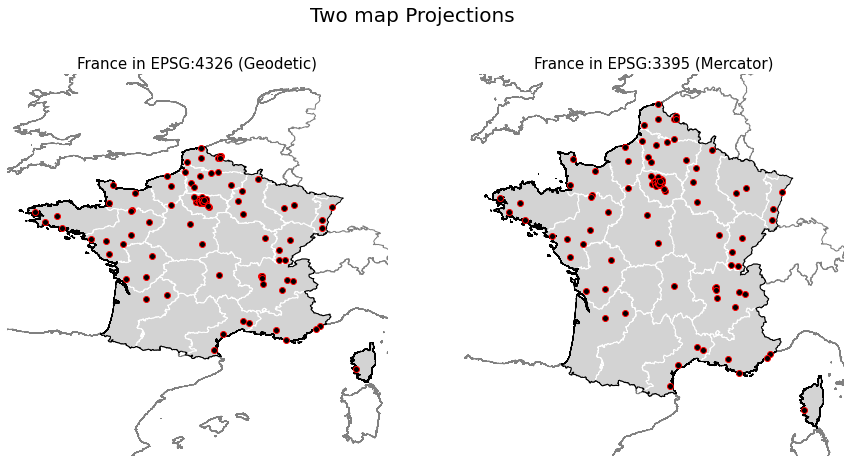

In [28]:
#Combining the two maps
#figsize : (float, float), as width, height
#f, ax = plt.subplots(1, figsize=((maxx2 - minx2)/150000,(maxy2 - miny2)/150000))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))
fig.suptitle('Two map Projections', fontsize=20)
ax1.set_title('France in EPSG:4326 (Geodetic)', fontsize=15)
ax2.set_title('France in EPSG:3395 (Mercator)', fontsize=15)
ax1.set(xlim=(minx1, maxx1), ylim=(miny1, maxy1))
ax2.set(xlim=(minx2, maxx2), ylim=(miny2, maxy2))
ax1.set_axis_off()
ax2.set_axis_off()

#plotting on the defined axis => ax1=ax1
eea_FR.plot(color='lightgrey', edgecolor='white', ax=ax1)
rdf.plot(facecolor='none', color='none', edgecolor='grey', ax=ax1)
eea_FRA.plot(facecolor='none', color='none', edgecolor='black', ax=ax1)

#plotting on the defined axis => ax=ax2
eea_FR_rp.plot(color='lightgrey', edgecolor='white', ax=ax2)
rdf_rp.plot(facecolor='none', color='none', edgecolor='grey', ax=ax2)
eea_FRA_rp.plot(facecolor='none', color='none', edgecolor='black', ax=ax2)

# In this example the points are on, and saved with the image, to prove that the 
# method is returnin the desired result.
# The code is intended to run without the contol points
geo_FR_df.plot(ax=ax1, facecolor='black', edgecolor='red')
points.plot(ax=ax2, facecolor='black', edgecolor='red')

plt.savefig('FRA_map1.eps', dpi=1080, bbox_inches='tight')
plt.show()



This is the example background map, with France in grey, and white provincial boundaries, the borders of the countries surrounding France are set to dark grey without a fill. 

When you are running this code with your own data, the layout can be set to your personal preferences. I like background maps to be as neutral as possible so that the attention is drawn to the essential elements of the map, in this case, the major cities in France.<br>
<br>


## Preparing the export
The next section of the code is preparing the formatted figure, as a background map, to be saved in a GeoTIFF format. The advantage of using the GeoTiff format when exporting is because metadata information is embedded in the image.
When using the exported GeoTiff in a new figure, the metadata will be used to reconstruct the background image, including projection, pixel size, and figure dimensions.

### Data preparation
Data visualisation of the background map is not necessary, the final (right side) figure is handled in memory.

In [29]:
#using the right image without plotting
#figsize : (float, float), as width, height
f, ax = plt.subplots(1, figsize=((maxx2 - minx2)/150000,(maxy2 - miny2)/150000))
#plotting on the defined axis => ax=ax2
ax.set(xlim=(minx2, maxx2), ylim=(miny2, maxy2))
eea_FR_rp.plot(color='lightgrey', edgecolor='white', ax=ax)
rdf_rp.plot(facecolor='none', color='none', edgecolor='grey', ax=ax)
eea_FRA_rp.plot(facecolor='none', color='none', edgecolor='black', ax=ax)
ax.set_axis_off()

# In this example the points are on, and saved with the image, to prove that the
# method is returnin the desired result.
# The code is intended to run without the contol points
points.plot(ax=ax, facecolor='black', edgecolor='red')

# Removing the white spaces around the image
f.tight_layout(pad=0)
plt.close(f)

# There are methods to work with the data in the figure by convering the image 
# to a data array.
# In NumPy the image is read from the MatPlotLib libary as a Canvas.
data = np.frombuffer(f.canvas.tostring_rgb(), dtype=np.uint8)
print(data)
data.shape

# However, obtaining the data in this form is not useful because it's a one 
# dimention shape, # with no information about the numner of rows and columns.

[255 255 255 ... 255 255 255]


(2333769,)

### Converting the figure
This is the most crucial step in the process, the figure is converted to a multi-dimensional array, storing the pixels in width and height, and the colour depth. Please, follow the link below for detailed information about the method.

In [0]:
# MatPlotLib as another method to convert a Canvas to an Array:
# https://matplotlib.org/3.1.1/gallery/user_interfaces/canvasagg.html

canvas = FigureCanvasAgg(f)
# Save the figure to a string.
canvas.draw()
s, (width, height) = canvas.print_to_buffer()

# Convert to a NumPy array.
X = np.frombuffer(s, np.uint8).reshape((height, width, 4))

### Exploring the output



In [31]:
# The result of the scaling earlier is that we have now a new matrix with almost 
# equal dimentions
# The pixel resolution in this example should therefore also be almost equal.
X.shape

(883, 881, 4)

In [32]:
# The original colours are stored in the last dimention of the image matrix, as 
# a list with four atributes.
# In this example the colours are compressed to a grey value, the created map is 
# a background map with neutral coulours, # there is no need to store the 
# original values in a multi-band image.
print(X[:,:,0])

# Converting four bands to Grey(Y) = 0.2989 R + 0.5870 G + 0.1140 B 
# The fourth column is used for alpha (trasparantcy) which is not used in 
# this example and is set to 0 
Y = (0.2989 * (X[:,:,0])) + (0.5870 * (X[:,:,1])) + (0.1140 * (X[:,:,2]))



[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [33]:
# Checking the dimentions of the new matrix holding the grey values
Y.shape

(883, 881)

In [34]:
#Checking a grey value in the middel of the map (France)
Y[400,400]

210.9789

### Storing the data array as a GeoTiff
In the next cell/step of this NoteBook the figure is exported to an image using the GDAL libary, with:
- .GetDriverByName: export as geotiff 
- .SetGeoTransform: to preserve the coordinates
- osr.SpatialReference: as well as the projection, in this example hard coded (3395)

<br>


**Creating the image from the figure data, with:**
- newRasterfn: File Name (str)
- rasterOrigin: upper left corner (minx, maxy)
- pixelWidth: cell dimetion (w)
- pixelHeight: cell dimetion (h)
- array: the flattend data from the figure (NxM)



In [35]:
import gdal, ogr, os, osr

# Export array to raster
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    #newRasterfn: File Name
    #rasterOrigin: upper left corner
    #pixelWidth: cell dimetion (w)
    #pixelHeight: cell dimetion (h)
    #array: the data from the figure
    
    cols = array.shape[1] 
    rows = array.shape[0] 
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, -pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(3395)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    print("Image saved to disk")

# Creating the Image from a Figure
def createImageFromFigure(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    # depending of the use of the image the data has to be reversed, in this 
    # example the data is not revervesed
    # because the function reading the data will take care of projecting the 
    # data correctly when reading the created metadata
    reversed_arr = array[::-1]                                                   # reverse array so the tif looks like the array
    
    # Uncomment / Comment the function call you want to use:
    # array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster
    array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array)          # convert array to raster


# Number of rows and columns in the image
cols = Y.shape[1]
rows = Y.shape[0]

# Ideally the pixel dimentions are equql (or close to equal) when creating a 
# image from the figure in this example the sizes are almost indentical (~2084)
print("Rechecking the dimentions")
print("cols (X): ", cols, " // rows (Y): ", rows)
pixelWidth =  (maxx2 - minx2) / (cols)
pixelHeight = (maxy2 - miny2) / (rows)

print("Cell size: ", int(pixelWidth), " (w) , ", int(pixelHeight), " (h)")

#Obtaining the upper left corner coordinates
rasterOrigin = (minx2, maxy2)
print("rasterOrigin: ", rasterOrigin)

# Name of the image, the image will be saved in the location of the NoteBook
newRasterfn = 'test3b.tif'

# Creating the image from the figure data, with:
# newRasterfn: File Name
# rasterOrigin: upper left corner
# pixelWidth: cell dimetion (w)
# pixelHeight: cell dimetion (h)
# array: the data from the figure
createImageFromFigure(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,Y)



Rechecking the dimentions
cols (X):  881  // rows (Y):  883
Cell size:  2084  (w) ,  2084  (h)
rasterOrigin:  (-672599.7581629481, 6738853.145639915)
Image saved to disk


## Summary

This conclude the first part of the code, to sumarise what we have done so far:
<ol>
<li>Vector data was loaded to a MatPlotLib figure, including:</li>
<ol>
<li>Point data: cities</li>
<li>Polygon data: administrative boundaries</li>
</ol>
</li>
<li>Reprojection of the data</li>
<ol>
<li>Original: epsg:4326</li>
<li>Reprojected: EPSG:3395</li>
</ol>
<li>Obtained the figure data in an array (MxN)</li>
<li>Obtained the parameters for the meta data</li>
<li>Stored the information as a GeoTiff</li>
</ol>
<br>

## Visualising the Exported Image

This section of the NoteBook is relatively short, demonstrating how to load the data, and use the image as a background map, to show new information.

The main objective of this Notebook was to create an easy procedure to include standard background images to other NoteBooks, without the need to manage the data needed to make the map. This next code section can therefore also be used in related Notebooks to the project, but without the overhead of required data and code to produce the map.

There are only two tasks are remaining:

1. the loading of the created GeoTiff
2. the displaying of the created Geotiff

The displayed figure can be enriched with much more information, relative to the analysis and the NoteBook.




### Reloading the check point
Looking at the extent of the image, and checking the entries in the metadata, is one way to verify that the process was successful. Reimporting and displaying the cities on the exported map will give a visual confirmation that the reprojection of the data, the conversion of the figure, and reconstruction of the picture as a new figure, all worked as designed.

In [0]:
# Reintroducing libaries for when the code is run from another Notebook
# No new libaries and needed code are enabled in this example, 
# please check your settings before running
#import numpy as np
#import pandas as pd
#import geopandas as gpd
#import matplotlib.pyplot as plt

#import rasterio
#import rasterio.plot
#from affine import Affine


In [37]:
# Reloading the points
#file_path = r"<<correct the path>>\FRA_adm\FRA_gaz\FRA_CitiesTop100_edit.txt"
#city_df = pd.read_csv(file_path, sep=";")

# Open point data with geopandas
#geo_FR_df = gpd.GeoDataFrame(city_df,geometry=gpd.points_from_xy(city_df.LON, 
#                                                                 city_df.LAT))

# Setting the original projection of the points
#geo_FR_df.crs = 'epsg:4326'

# Changing the projection to match the projection of the image
# Note: when an image is created setting the projection can be done by reading 
# the .crs information of the image, # but in this case the points are loaded 
# before the image is constructed so the projection change can be checked
# visually.

#points = geo_FR_df.to_crs(epsg=3395)
print("Current projection: ", points.crs)

Current projection:  epsg:3395


### Loading the exported image

The below code will 
- read in file with geotiff geographic information
- use the metadata information to recreate the image
 - Generate X and Y grid locations
 - Check the bounding coodinates
 - Reading the data (colour)
 - checking the orientation (flip the array)

In [38]:
# directory path and file name
#path = r'D:\Study\Coding\Twitter\DataVis/'
file_in = 'test3b.tif'

# read in file with geotiff geographic information
# src = rasterio.open(path + file_in) # --> use locally
src = rasterio.open(file_in)

# print out metadata information
print("check metadata information")
for k in src.meta:
    print(k,src.meta[k])

# Retrieve the affine transformation
if isinstance(src.transform, Affine):
     transform = src.transform
else:
     transform = src.affine

N = src.width
M = src.height
dx = transform.a
dy = transform.e
minx = transform.c
maxy = transform.f

print("new coords")
print("upper left: ", minx, maxy)
print("cell size: ", dx, dy)
print("columns and rows:", M, N)
print("bounds: ", src.bounds)

# Generate X and Y grid locations
xdata = minx  + dx*np.arange(N+1)
ydata = maxy  + dy*np.arange(M,-1,-1)

print("check new coodinates")
extent = [xdata[0], xdata[-1], ydata[0], ydata[-1]]
          
print("extent: ",  [xdata[0], xdata[-1], ydata[0], ydata[-1]])
print("extent: ", extent)

#Reading the data, and checking the orientation
data_in = src.read(1)
print(dy)
if dy < 0:
    print("flip the array")
    dy = -dy
    data_in = np.flip(data_in, 0)


check metadata information
driver GTiff
dtype uint8
nodata None
width 881
height 883
count 1
crs EPSG:3395
transform | 2084.97, 0.00,-672599.76|
| 0.00,-2084.24, 6738853.15|
| 0.00, 0.00, 1.00|
new coords
upper left:  -672599.7581629481 6738853.145639915
cell size:  2084.9721041149846 -2084.240959576966
columns and rows: 883 881
bounds:  BoundingBox(left=-672599.7581629481, bottom=4898468.378333454, right=1164260.6655623533, top=6738853.145639915)
check new coodinates
extent:  [-672599.7581629481, 1164260.6655623533, 4898468.378333454, 6738853.145639915]
extent:  [-672599.7581629481, 1164260.6655623533, 4898468.378333454, 6738853.145639915]
-2084.240959576966
flip the array


## Displaying the results of the conversion
In the image below the red dots are the points (city), loaded in the previous paragraph, and they are falling perfectly over the points added to the map before. In the first map, the dots were displayed as black dots with a red outline. In the conversion process, all the colours are recoded to a "grey" value, if the conversion had been unsuccessful, there would be a "grey/black" shading around the red dots.

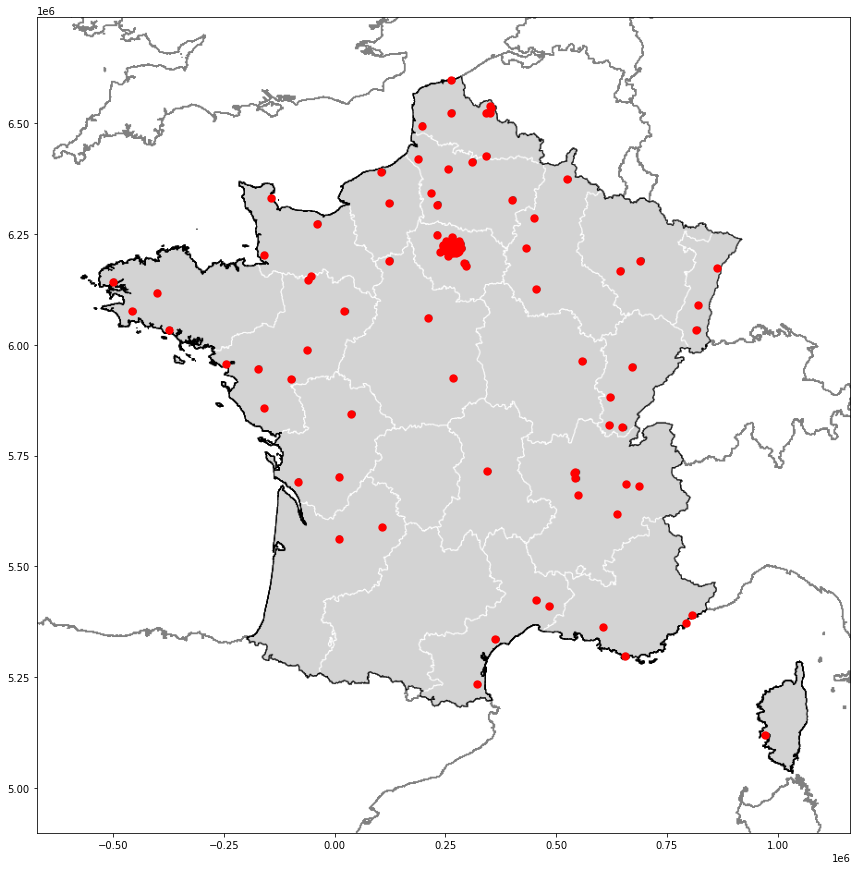

In [39]:
# Creating the new figure with the image as background
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(src, ax=ax, cmap='gist_gray')
points.plot(ax=ax, facecolor='red', markersize=40, linewidth=2,alpha=1)         #edgecolor='red',
plt.show()

#Conclusion
It is possible to create a Geo-Referencing image from a Figure (GeoTiff), and then to use this new image as a background in a MatPlotLib figure.

Using a preconfigured background map, which can be easily shared, could help when collaborating within a team because the image will not distract from the other information exchanged in the project. However, among all the positive points of having a standard background map, there is one (or more) downside. Most people like dynamic maps, the constructed map is static and can only be used for one purpose and for one scale (range). So, when zooming and panning over the map is part of the workflow having a standard static map will not help in the exploratory phase of a project.

#Final remarks
I hope that this NoteBook will help to reduce the transfer of large datasets, which are only used to display static background maps, and don't contribute to the storytelling. To give an example, I am going to use the technique developed in this NoteBook for the next phase of my overarching project. In this sub-project, I will need lightweight background images for all the maps in my next project: "clustering event data by location and time."

I apologise, as you might have noticed, this article doesn't contain all the code from the NoteBook (which can be downloaded from the link below). The text is already long and technical in places, adding more code would have doubled the length and not improved the readability.

Please, don't hesitate to reach out, I am more than happy to give more information about the methods used, or correct the parts of the code which might not be are behaving as expected when trying it out with other data than used in this demo.


Thank you for reading, and I hope this post has helped you to solve a problem or gave you an idea for the next project.



In [0]:
# some housekeeping
!rm -rf "/AdministrativeData"